# Etude de l'évolution des prix et de la volatilité du marché de l'électricité, du diesel et du gaz

## Méthodologie classique de simulation du prix d'un actif

D'après la littérature, un actif financier tel que le prix de l'électricité peut être modélisé par un mouvement brownien géométrique tel que :

$$ dP_t = \mu P_t dt +\sigma P_t dW_t $$

Avec : 
- $P_t$ : Le prix de l'électricité moyen à l'horizon t.
- $\mu_t$ le taux de drift ou rendement attendu moyen (tendance à long terme).
- $\sigma_t$ la volatilité relative, qui mesure la dispersion autour de la tendance.
- $W_t$ : Mouvement brownien standard. $dW_t$ suit la loi normale $N(0, dt)$.


Ainsi, nous pouvons écrire comme solution : 

$$P_{t} = P_0e^{(\mu_t - \frac{\sigma_t²}{2}) +\sigma_tZ_t} \ (*)$$

Avec : 
- $Z_t$ : Le bruit aléatoire suivant une loi normale $N(0,1)$.

Pour appliquer une telle formule au prix du gaz, du gazole et de l'électricité, nous devons extraire $\mu$ et $\sigma$ des données historiques annuelles.

## 1ère méthodologie : Prédiction du prix par un mouvement brownien géométrique

### Rendements logarithmiques

Utilisons les rendements logarithmiques pour linéariser les variations relatives des prix : 

$$R_t = \ln(\frac{P_t}{P_{t-1}})$$

Puis en utilisant la solution (*) : 

$$R_t = \ln(P_t) - \ln(P_{t-1}) = (\mu - \frac{\sigma²}{2})\Delta t + \sigma \Delta W_t$$

Ainsi, les rendements log-mensuels $R_t$ suivent une distribution normale $N((\mu - \frac{\sigma²}{2})\Delta t, \ \sigma² \Delta t)$ (**)

### Relation entre les moments empiriques et $\mu$, $\sigma$

La moyenne empirique des rendements logarithmiques est donnée par : 

$$\bar{R} = \frac{1}{T}\sum_{t=1}^T R_t$$

En prenant la moyenne théorique de la loi normale (**), alors nous pouvons écrire :

$$E [R_t] = (\mu - \frac{\sigma²}{2})\Delta t$$

Donc : 

$$\mu = \frac{E[R_t]}{\Delta t} + \frac{\sigma²}{2}$$

Parallèlement, la variance empirique des rendementsl logarithmiques est donnée par : 

$$Var(R_t) = \frac{1}{T-1}\sum_{t=1}^T (R_t-\bar{R})²$$

Avec la variance théorique : 

$$Var(R_t) = \sigma²\Delta t$$

De manière analogue : 

$$\sigma = \sqrt{\frac{Var(R_t)}{\Delta t}}

On a donc : 

$$\mu = \frac{\bar{R}}{\Delta t}+\frac{\sigma²}{2}$$

$$\sigma = \sqrt{\frac{Var(R_t)}{\Delta t}}

## Analyse historique du prix de l'électricité

Hypothèse : Pour une entreprise dont la consommation est supérieure à 500 et strictement inférieure à 2000 MWh par an.


In [273]:
#Import des librairies
import pandas as pd
import numpy as np

#Statistiques
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [274]:
df = pd.read_csv("C:/Users/simon.senegas/Documents/Model_TCO_V11.3/Bibliographie/energy prices/prix elec/2.2.-Prix-industriels-Electricite.2024-11.csv", encoding="latin-1", sep=";")
df["date"] = pd.to_datetime(df["PERIODE"], format="%Y-%m")
df = df.sort_values(by='PERIODE')

In [275]:
df = df.set_index("date").drop(columns="PERIODE")
df = df.groupby(pd.Grouper(freq="6MS")).mean()
df.head()

,PX_ELE_I_TTES_TRANCHES
date,
2007-01-01,6.990357
2007-07-01,6.583343
2008-01-01,7.306586
2008-07-01,7.043114
2009-01-01,7.959871


<Axes: xlabel='date'>

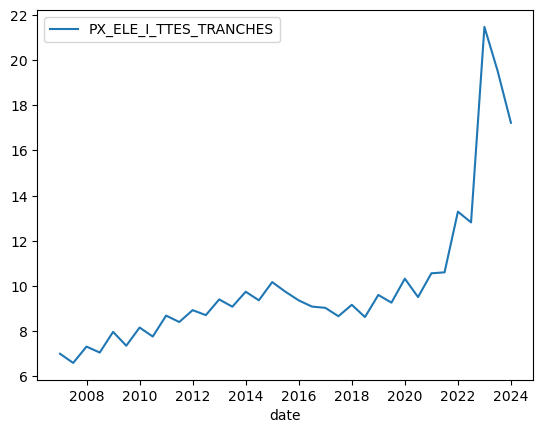

In [276]:
sns.lineplot(df)

In [277]:
log_returns = np.log(df/df.shift(1)).dropna()

In [278]:
#Hypothèses de normalité des rendements logarithmiques
from scipy import stats
jarque_bera_result = stats.jarque_bera(log_returns)
shapiro_result = stats.shapiro(log_returns)

print(jarque_bera_result)
print(shapiro_result)

SignificanceResult(statistic=87.79335442704108, pvalue=8.628102827679853e-20)
ShapiroResult(statistic=0.7858737115442598, pvalue=1.3822506146282847e-05)


Les tests de Shapiro-Wilk et de Jarque-Bera montrent que la distribution des rendements logarithmiques est asymétrique et dispose de queues épaisses (Jarque-Bera >> 5 et p-value <0.05, Stat Shapiro > 0.05, p-value <0.05). Les rendements logarithmiques ne suivent pas une loi normale, et nous ne pouvons pas appliquer un mouvement brownien géométrique. Nous pourrions améliorer le modèle en ajoutant un processus de Poisson pour simuler des sauts à cause de la grande volatilité mensuelle, mais prenons plutôt un modèle classique du type ARIMA.

### Modèle de prédiction du prix de l'électricité type ARIMA

In [279]:
df = df.rename(columns={"PX_ELE_I_TTES_TRANCHES":"prix"})
log_df = np.log(df)

In [280]:
def analyze_stationarity(ts_data: pd.Series):
    """Test de Dickey-Fuller. On teste l'hypothèse H_0 : Il existe une racine unitaire, avec son alternative H_1, il n'existe pas de racine unitaire.
    Args:
        ts_data (pd.Series): Processus ou série temporelle

    Returns:
        str : Analyse des différents tests (coefficient gamma, p-value associée, valeurs critiques à 1%, 5% et 10%)
    """
    result = adfuller(ts_data, autolag='AIC')
    
    return {
        'Test statistic': result[0],
        'p-value': result[1],
        'critical Values': result[4]
    }

In [281]:
analyze_stationarity(log_df)

{'Test statistic': 0.4605661300741806,
 'p-value': 0.9836239499425175,
 'critical Values': {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216}}

La statistique de test est très supérieure à toutes les valeurs critiques, et la p-value est supérieure à 0.05. Une racine unitaire existe encore, donc d > 0.

In [282]:
def iterative_differenciation(ts):
    """
    Prépare les données mensuelles pour l'analyse ARIMA.
    
    Parameters:
    data (pd.DataFrame): DataFrame avec colonnes 'date' et 'prix'
    
    Returns:
    tuple: (données préparées, ordre de différenciation, composante saisonnière)
    """
    
    stationary_test = analyze_stationarity(ts)
    d = 0 
    
    # Différenciation jusqu'à obtention de la stationnarité
    while stationary_test['p-value'] > 0.05 and stationary_test['critical Values']['5%'] < stationary_test['Test statistic']:
        ts = ts.diff().dropna()
        stationary_test = analyze_stationarity(ts)
        d += 1
    
    return ts, d

In [283]:
ts, d = iterative_differenciation(log_df)
print(f'Ordre de différenciation : {d}')

Ordre de différenciation : 1


In [284]:
analyze_stationarity(ts)

{'Test statistic': -8.749480784190437,
 'p-value': 2.862362758838708e-14,
 'critical Values': {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216}}

Après une première différenciation, la statistique de test est inférieure à la valeur critique au seuil de 1%, et la p-value est inférieure à 1%. Nous pouvons alors supposer que la série résultante est stationnaire.

<Axes: xlabel='date'>

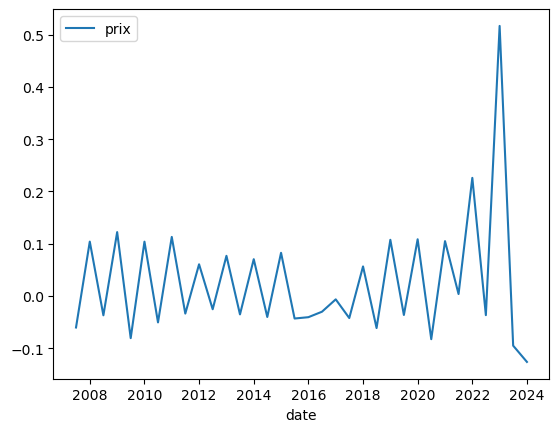

In [285]:
sns.lineplot(ts)

### Analyse de l'autocorrélation et de l'autocorrélation partielle

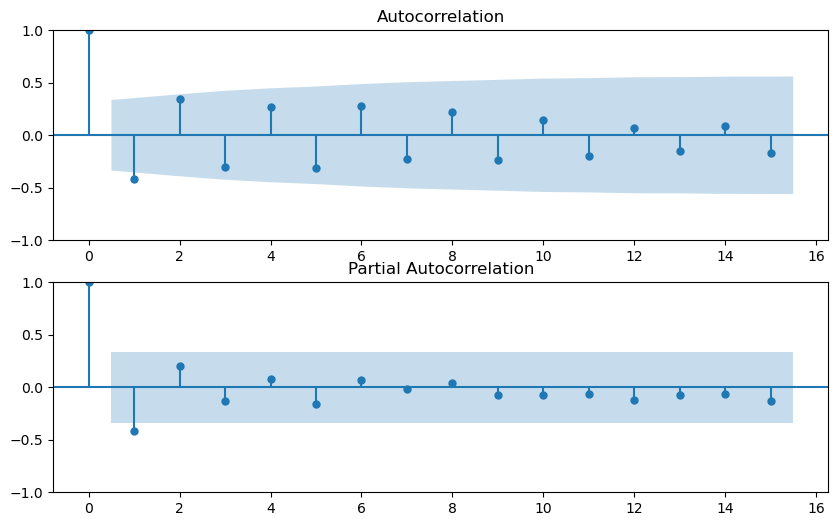

In [286]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
sm.graphics.tsa.plot_acf(ts.dropna(), lags=15, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts.dropna(), lags=15, ax=ax[1])
plt.show()

Selon les graphiques, les ordres p et q sont égaux à 1. Il n'y a pas de saisonnalité observée.

### Modèle ARIMA (1,1,1)

c:\Users\simon.senegas\AppData\Local\anaconda3\envs\Working_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\simon.senegas\AppData\Local\anaconda3\envs\Working_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                   prix   No. Observations:                   35
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  29.607
Date:                Tue, 11 Feb 2025   AIC                            -53.214
Time:                        11:13:59   BIC                            -48.635
Sample:                    01-01-2007   HQIC                           -51.653
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9997      0.011    -89.892      0.000      -1.021      -0.978
ma.L1          0.9828      0.304      3.231      0.001       0.387       1.579
sigma2         0.0094      0.002      4.034      0.0

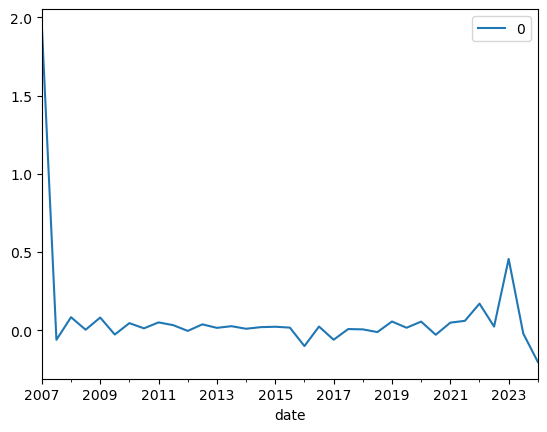

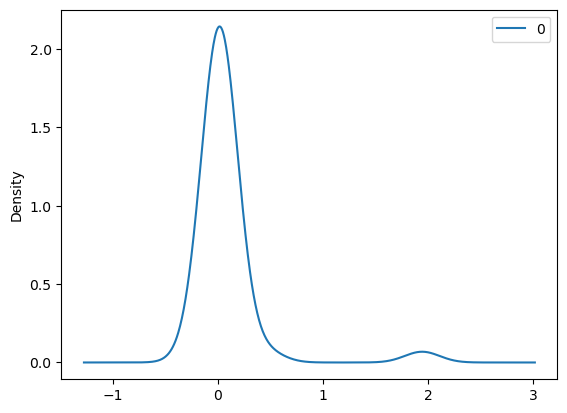

In [287]:
model = sm.tsa.statespace.SARIMAX(log_df, order=(1,1,1)) # seasonal_order=(0,1,0,6))
model_elec= model.fit(maxiter=1000)
print(model_elec.summary())

# plot residual errors
residuals = pd.DataFrame(model_elec.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()

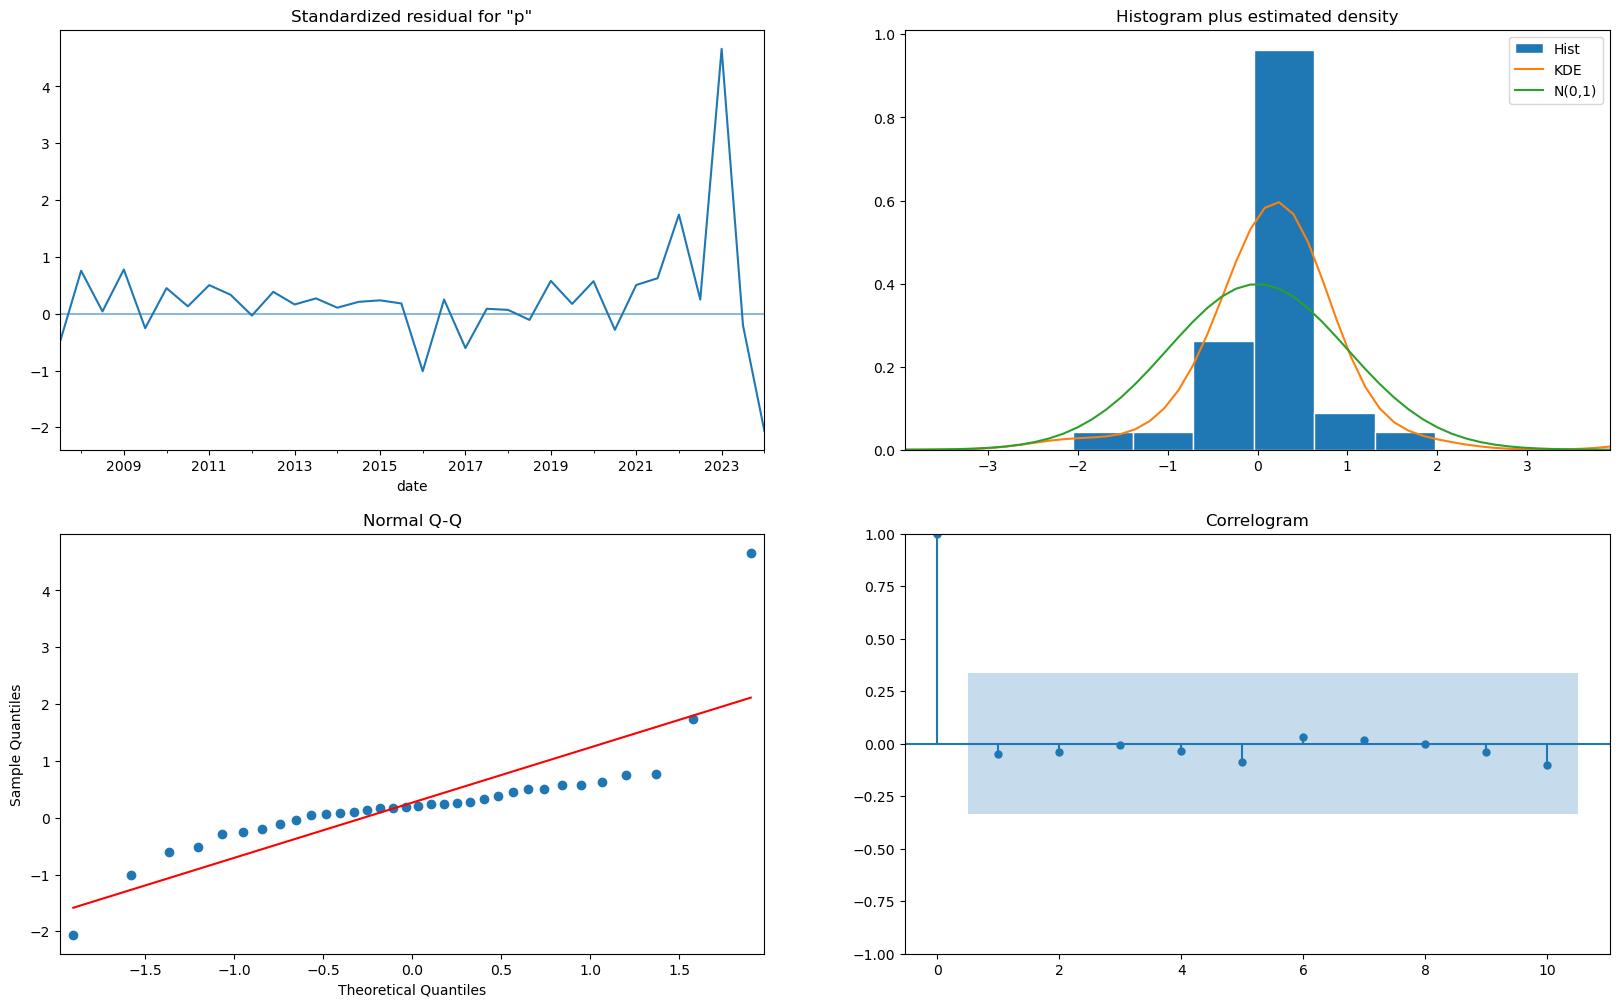

In [288]:
model_elec.plot_diagnostics(figsize = (20, 12))
plt.show()

In [289]:
print(f"L'erreur absolue moyenne du modèle SARIMAX élec est de : {np.round(np.exp(model_elec.mae)*1E1, 3)} €/MWh")

L'erreur absolue moyenne du modèle SARIMAX élec est de : 11.165 €/MWh


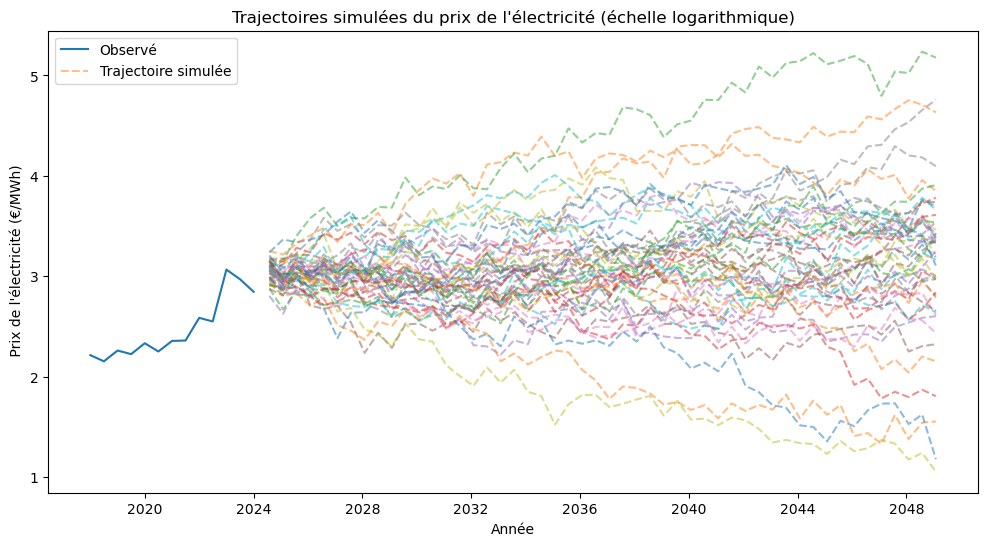

In [290]:
forecast_steps = 50   
n_simulations = 50
simulated_paths = [] 

last_index = log_df.index[-1]

for i in range(n_simulations):
    sim = model_elec.simulate(forecast_steps, anchor=last_index)

    sim.index = pd.date_range(start=last_index, periods=forecast_steps+1, freq='6ME')[1:]
    
    simulated_paths.append(sim)

### Visualisation 
plt.figure(figsize=(12, 6))

visu_elec = log_df['2018':]
plt.plot(visu_elec.index, visu_elec, label='Observé')

for i, sim in enumerate(simulated_paths):
    plt.plot(sim.index, sim, linestyle='--', alpha=0.5,
             label='Trajectoire simulée' if i == 0 else None) 

plt.xlabel('Année')
plt.ylabel(" Prix de l'électricité (€/MWh)")
plt.title("Trajectoires simulées du prix de l'électricité (échelle logarithmique)")
plt.legend(loc='upper left')
plt.show()

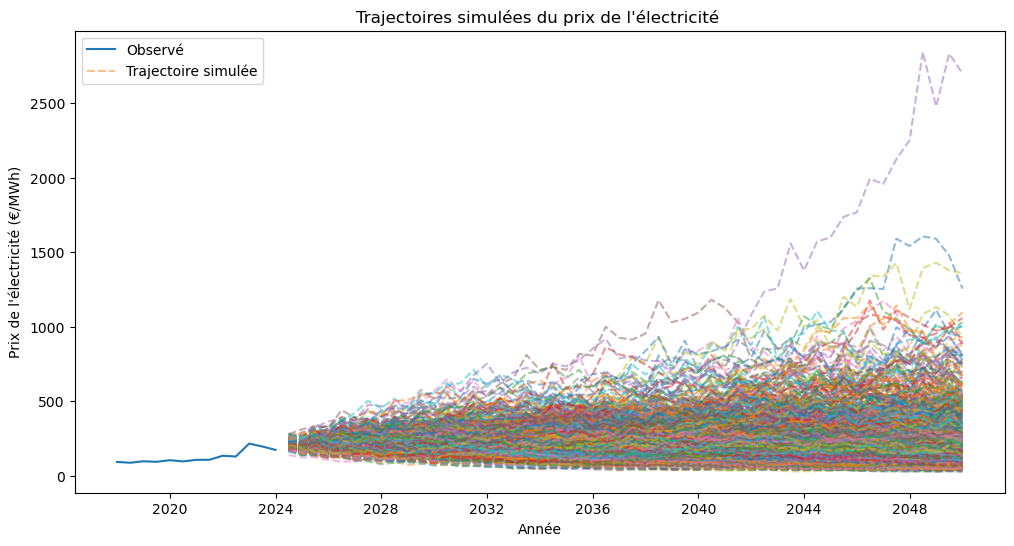

In [297]:
forecast_steps = 52   
n_simulations = 1000
simulated_paths = [] 

last_index = log_df.index[-1]

for i in range(n_simulations):
    sim = model_elec.simulate(forecast_steps, anchor=last_index, random_state=i)

    sim.index = pd.date_range(start=last_index, periods=forecast_steps+1, freq='6MS')[1:]
    
    simulated_paths.append(np.exp(sim)*1E1)

### Visualisation 
plt.figure(figsize=(12, 6))

visu_elec = np.exp(log_df['2018':])*1E1
plt.plot(visu_elec.index, visu_elec, label='Observé')

for i, sim in enumerate(simulated_paths):
    plt.plot(sim.index, sim, linestyle='--', alpha=0.5,
             label='Trajectoire simulée' if i == 0 else None) 

plt.xlabel('Année')
plt.ylabel("Prix de l'électricité (€/MWh)")
plt.title("Trajectoires simulées du prix de l'électricité ")
plt.legend(loc='upper left')
plt.show()

In [298]:
simulated_paths = pd.DataFrame(simulated_paths)

In [307]:
log_df.iloc[-1].item()

2.8462689243415107

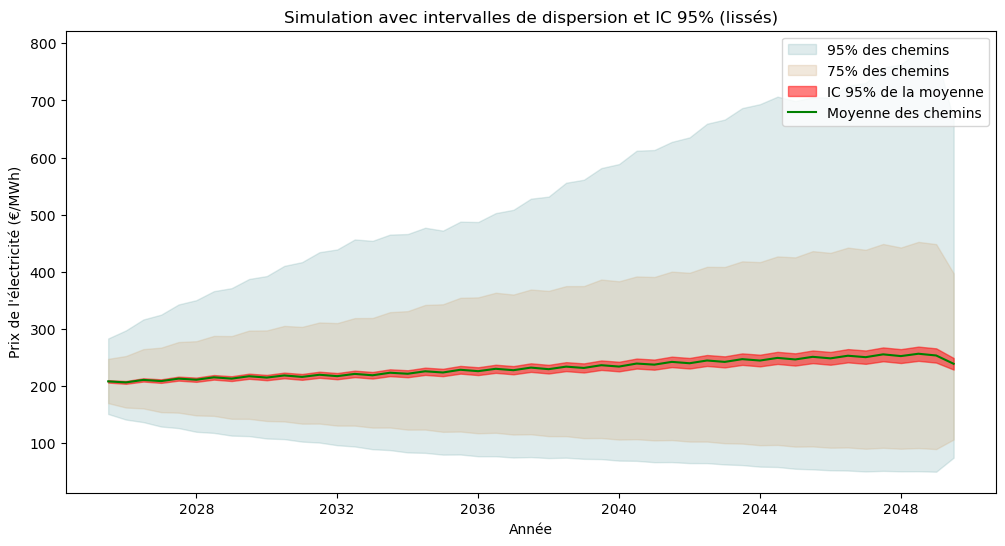

In [310]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction de moyenne mobile pour le lissage
def moving_average(series, window=40):
    return series.rolling(window=window, center=True).mean()

# Nombre de trajectoires
n = simulated_paths.shape[0]  

# Calcul des quantiles pour la dispersion
q025 = simulated_paths.quantile(0.025)  # 2.5% (bornes 95%)
q975 = simulated_paths.quantile(0.975)  # 97.5% (bornes 95%)
q125 = simulated_paths.quantile(0.125)  # 12.5% (bornes 75%)
q875 = simulated_paths.quantile(0.875)  # 87.5% (bornes 75%)

# Calcul de la moyenne et de l'IC 95%
mean_series = simulated_paths.mean()
std_series = simulated_paths.std()
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)  # Valeur de Student
ic_upper = mean_series + t_critical * (std_series / np.sqrt(n))  # IC sup
ic_lower = mean_series - t_critical * (std_series / np.sqrt(n))  # IC inf

# Lissage avec une moyenne mobile
window_size = 5  # Taille de la fenêtre pour le lissage
q025_smooth = moving_average(q025, window=window_size)
q975_smooth = moving_average(q975, window=window_size)
q125_smooth = moving_average(q125, window=window_size)
q875_smooth = moving_average(q875, window=window_size)
mean_smooth = moving_average(mean_series, window=window_size)
ic_upper_smooth = moving_average(ic_upper, window=window_size)
ic_lower_smooth = moving_average(ic_lower, window=window_size)

# Création de la figure
fig = plt.figure(figsize=(12,6))

# Intervalle de dispersion 95% (quantiles)
plt.fill_between(simulated_paths.columns, q025_smooth, q975_smooth, 
                 alpha=0.2, label="95% des chemins", color="cadetblue")

# Intervalle de dispersion 75% (quantiles)
plt.fill_between(simulated_paths.columns, q125_smooth, q875_smooth, 
                 alpha=0.3, label="75% des chemins", color="tan")

# Intervalle de confiance 95% sur la moyenne
plt.fill_between(simulated_paths.columns, ic_lower_smooth, ic_upper_smooth, 
                 alpha=0.5, label="IC 95% de la moyenne", color="red")

# Courbe de la moyenne lissée
sns.lineplot(x=simulated_paths.columns, y=mean_smooth, color="green", label="Moyenne des chemins")

# Affichage
plt.legend()
plt.xlabel("Année")
plt.ylabel("Prix de l'électricité (€/MWh)")
plt.title("Simulation avec intervalles de dispersion et IC 95% (lissés)")
plt.show()


In [340]:
simulated_paths

,2024-07-01 00:00:00,2025-01-01 00:00:00,2025-07-01 00:00:00,2026-01-01 00:00:00,2026-07-01 00:00:00,2027-01-01 00:00:00,2027-07-01 00:00:00,2028-01-01 00:00:00,2028-07-01 00:00:00,2029-01-01 00:00:00,...,2046-07-01 00:00:00,2047-01-01 00:00:00,2047-07-01 00:00:00,2048-01-01 00:00:00,2048-07-01 00:00:00,2049-01-01 00:00:00,2049-07-01 00:00:00,2050-01-01 00:00:00,2024-01-01 00:00:00,trajectory_number
0,213.070349,205.574775,230.691791,229.174846,219.755118,191.936613,197.732711,164.332228,209.376237,184.904106,...,329.917176,267.799410,303.024476,309.324630,327.779501,274.341377,321.991561,263.327808,172.234,0
1,218.881240,181.039554,215.935462,197.179699,190.899641,169.764167,186.233731,175.229823,173.751594,143.276654,...,117.160220,110.797288,113.526743,113.216925,121.774256,119.382452,146.119653,139.203680,172.234,1
2,213.915278,219.828715,296.394225,283.228487,296.069304,255.854854,292.917244,267.042425,282.512004,259.858508,...,174.387452,148.128400,138.426874,124.292263,140.354397,141.061917,162.998570,190.507784,172.234,2
3,253.369104,223.205374,240.408394,179.067196,202.595650,200.618284,181.079424,172.584240,165.858755,169.421117,...,124.401233,119.128618,123.134903,118.916191,123.671360,125.785217,123.776884,118.128230,172.234,3
4,197.442298,198.098854,187.077963,199.602886,206.073539,196.202750,227.390244,226.838554,268.440361,255.245739,...,186.299812,175.982419,184.005301,172.429641,201.941862,206.207222,225.491270,230.771595,172.234,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,239.316742,242.864542,277.339371,269.154010,311.330306,300.688335,305.398134,274.563067,303.697385,280.027602,...,243.196823,249.986065,268.416119,258.470204,282.048887,293.951152,258.450152,247.962646,172.234,995
996,232.752644,220.349163,233.514232,177.811280,205.567692,210.467553,250.353263,244.871392,299.678060,324.263518,...,293.670669,255.747505,265.490373,259.218469,261.544226,244.769177,300.250600,275.245472,172.234,996
997,206.427107,178.144549,157.209764,146.149015,155.510240,159.114388,169.352476,139.349680,153.632348,149.074895,...,184.207441,157.354302,146.889662,146.895922,172.007804,152.320632,205.358266,210.179903,172.234,997
998,231.583852,254.086869,276.885273,230.332718,220.408235,204.214341,239.087437,248.859264,248.068288,210.879345,...,204.839989,185.094058,166.339262,138.725157,158.482965,150.002365,134.205738,110.240128,172.234,998


In [341]:
#simulated_paths[last_index] = np.exp(log_df.iloc[-1].item())*1E1

In [342]:
simulated_paths = simulated_paths.reset_index(drop=True)

In [343]:
simulated_paths["trajectory_number"] = simulated_paths.index

In [344]:
simulated_paths

,2024-07-01 00:00:00,2025-01-01 00:00:00,2025-07-01 00:00:00,2026-01-01 00:00:00,2026-07-01 00:00:00,2027-01-01 00:00:00,2027-07-01 00:00:00,2028-01-01 00:00:00,2028-07-01 00:00:00,2029-01-01 00:00:00,...,2046-07-01 00:00:00,2047-01-01 00:00:00,2047-07-01 00:00:00,2048-01-01 00:00:00,2048-07-01 00:00:00,2049-01-01 00:00:00,2049-07-01 00:00:00,2050-01-01 00:00:00,2024-01-01 00:00:00,trajectory_number
0,213.070349,205.574775,230.691791,229.174846,219.755118,191.936613,197.732711,164.332228,209.376237,184.904106,...,329.917176,267.799410,303.024476,309.324630,327.779501,274.341377,321.991561,263.327808,172.234,0
1,218.881240,181.039554,215.935462,197.179699,190.899641,169.764167,186.233731,175.229823,173.751594,143.276654,...,117.160220,110.797288,113.526743,113.216925,121.774256,119.382452,146.119653,139.203680,172.234,1
2,213.915278,219.828715,296.394225,283.228487,296.069304,255.854854,292.917244,267.042425,282.512004,259.858508,...,174.387452,148.128400,138.426874,124.292263,140.354397,141.061917,162.998570,190.507784,172.234,2
3,253.369104,223.205374,240.408394,179.067196,202.595650,200.618284,181.079424,172.584240,165.858755,169.421117,...,124.401233,119.128618,123.134903,118.916191,123.671360,125.785217,123.776884,118.128230,172.234,3
4,197.442298,198.098854,187.077963,199.602886,206.073539,196.202750,227.390244,226.838554,268.440361,255.245739,...,186.299812,175.982419,184.005301,172.429641,201.941862,206.207222,225.491270,230.771595,172.234,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,239.316742,242.864542,277.339371,269.154010,311.330306,300.688335,305.398134,274.563067,303.697385,280.027602,...,243.196823,249.986065,268.416119,258.470204,282.048887,293.951152,258.450152,247.962646,172.234,995
996,232.752644,220.349163,233.514232,177.811280,205.567692,210.467553,250.353263,244.871392,299.678060,324.263518,...,293.670669,255.747505,265.490373,259.218469,261.544226,244.769177,300.250600,275.245472,172.234,996
997,206.427107,178.144549,157.209764,146.149015,155.510240,159.114388,169.352476,139.349680,153.632348,149.074895,...,184.207441,157.354302,146.889662,146.895922,172.007804,152.320632,205.358266,210.179903,172.234,997
998,231.583852,254.086869,276.885273,230.332718,220.408235,204.214341,239.087437,248.859264,248.068288,210.879345,...,204.839989,185.094058,166.339262,138.725157,158.482965,150.002365,134.205738,110.240128,172.234,998


In [345]:
df_exportable = simulated_paths.melt(id_vars=["trajectory_number"], value_vars=simulated_paths.columns)

In [346]:
df_exportable = df_exportable.sort_values(by=["trajectory_number", "variable"]).reset_index(drop="True")

In [347]:
df_exp_grouped = df_exportable.groupby(by=["trajectory_number", pd.Grouper(key="variable", freq="YE")], as_index=False).mean()

c:\Users\simon.senegas\AppData\Local\anaconda3\envs\Working_env\Lib\site-packages\pandas\core\groupby\grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)


In [ ]:
df_exp_grouped["variable"] = df_exp_grouped["variable"].values.astype('<M8[Y]').floor("Y")

AttributeError: 'numpy.ndarray' object has no attribute 'floor'

In [359]:
df_exp_grouped["variable"] = df_exp_grouped["variable"].dt.year

In [361]:
df_exp_grouped.to_csv("20250211_price_electricity_test.csv")

In [362]:
from statsmodels.stats.diagnostic import het_arch

# Test d'Engle sur les résidus
test_arch = het_arch(model_elec.resid)
print("Statistique ARCH : ", test_arch[0])
print("p-value : ", test_arch[1])

Statistique ARCH :  6.308654973989411
p-value :  0.5042067087171077


## Analyse historique du prix du gaz 

La loi des rendements logarithmiques ne suit pas une loi normale ou log-normale, l'application d'un mouvement brownien pour construire une tendance de long terme devient nulle. Un modèle ARIMA (peut-être corrigé par une volatilité non constante (ARIMA-GARCH)) sera donc utilisé.

### Modèle ARIMA Gaz

In [131]:
df_gaz = pd.read_csv("C:/Users/simon.senegas/Documents/Model_TCO_V11.3/Bibliographie/energy prices/prix gaz/2.3.-Prix-industriels-Gaz.2024-11.csv", sep=";")
df_gaz = df_gaz.rename(columns={"PERIODE":"date" , "PX_GAZ_I_TTES_TRANCHES": "prix"})
df_gaz["prix"] = np.log(df_gaz["prix"])

In [132]:
df_gaz["date"] = pd.to_datetime(df_gaz["date"])
df_gaz.dtypes

date    datetime64[ns]
prix           float64
dtype: object

In [133]:
df_gaz = df_gaz.dropna()
df_gaz.shape

(210, 2)

In [134]:
df_gaz = df_gaz.groupby(pd.Grouper(key='date', freq='6MS')).mean() 

In [135]:
df_gaz.head()

,prix
date,
2007-01-01,1.111627
2007-07-01,1.155502
2008-01-01,1.210566
2008-07-01,1.354920
2009-01-01,1.279340


In [136]:
df_gaz.sort_index(inplace=True)

<Axes: xlabel='date', ylabel='prix'>

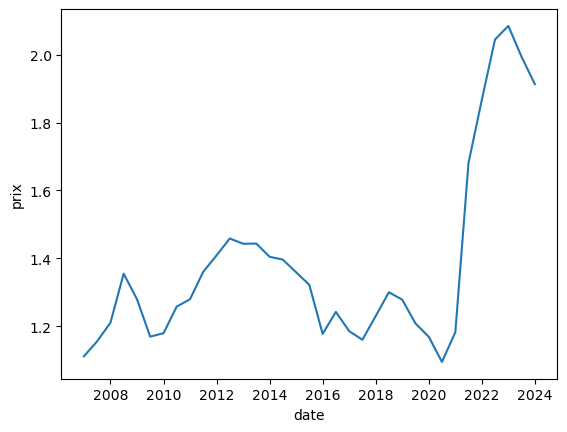

In [137]:
sns.lineplot(data = df_gaz, x=df_gaz.index, y=df_gaz["prix"])

In [138]:
#df_gaz = df_gaz[:"2020"]

### Analyse de la stationnarité

In [139]:
analyze_stationarity(df_gaz)

{'Test statistic': -1.824395483119805,
 'p-value': 0.36841902873866755,
 'critical Values': {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216}}

Le coefficient gamma est négatif, nous pouvons faire l'hypothèse que la série est stationnaire. Cependant, la p-value est inférieure à 5% et la valeur critique à 5% est inférieure à la statistique de test, ce qui infirme notre assertion. Le coefficient de différenciation d sera donc > 0.

In [140]:
ts, d = iterative_differenciation(df_gaz)
print(f'Différenciation ordre {d}')

Différenciation ordre 1


In [141]:
analyze_stationarity(ts)

{'Test statistic': -3.5445112150918234,
 'p-value': 0.006914887168406078,
 'critical Values': {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216}}

La statistique de test montre que $H_0$ est rejetée au seuil de 5%, et la p-value confirme cette hypothèse. Le processus est désormais stationnaire.


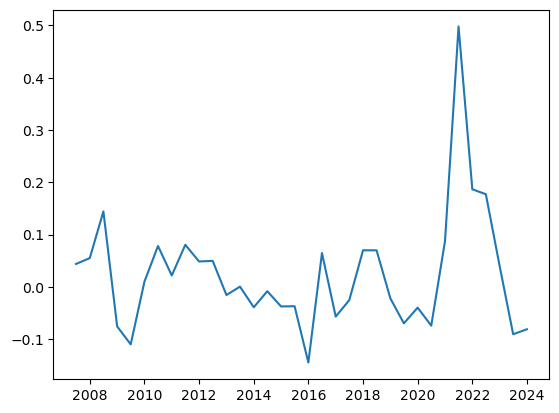

In [142]:
plt.plot(ts)

In [143]:
ts.head()

,prix
date,
2007-07-01,0.043875
2008-01-01,0.055064
2008-07-01,0.144354
2009-01-01,-0.075580
2009-07-01,-0.109928


### Autocorrélation et autocorrélation partielle (ACF, PACF)

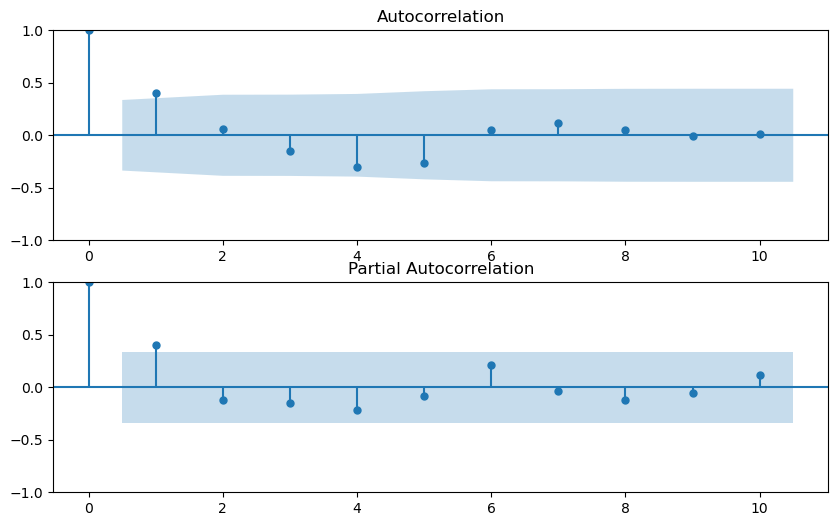

In [144]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
sm.graphics.tsa.plot_acf(ts.dropna(), lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts.dropna(), lags=10, ax=ax[1])
plt.show()

                               SARIMAX Results                                
Dep. Variable:                   prix   No. Observations:                   35
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  28.578
Date:                Tue, 11 Feb 2025   AIC                            -51.155
Time:                        10:18:40   BIC                            -46.576
Sample:                    01-01-2007   HQIC                           -49.594
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3071      0.396      0.776      0.438      -0.468       1.083
ma.L1          0.1449      0.388      0.373      0.709      -0.616       0.906
sigma2         0.0108      0.002      5.452      0.0

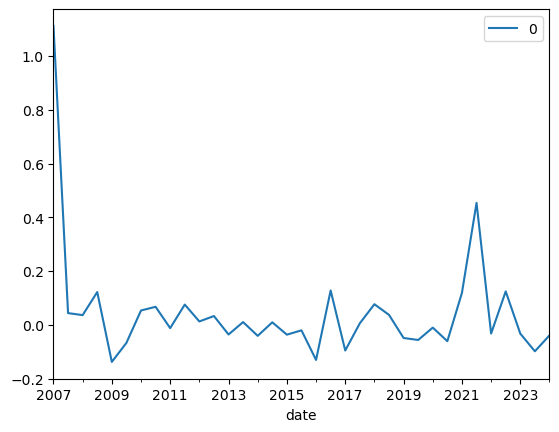

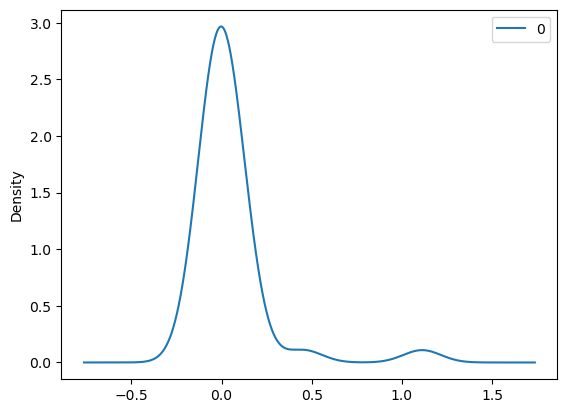

               0
count  35.000000
mean    0.044886
std     0.212405
min    -0.137619
25%    -0.039819
50%     0.005971
75%     0.060476
max     1.111627


In [146]:
model = sm.tsa.statespace.SARIMAX(df_gaz.asfreq('6MS'), order=(1,1,1)) # seasonal_order=(0,1,0,6))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

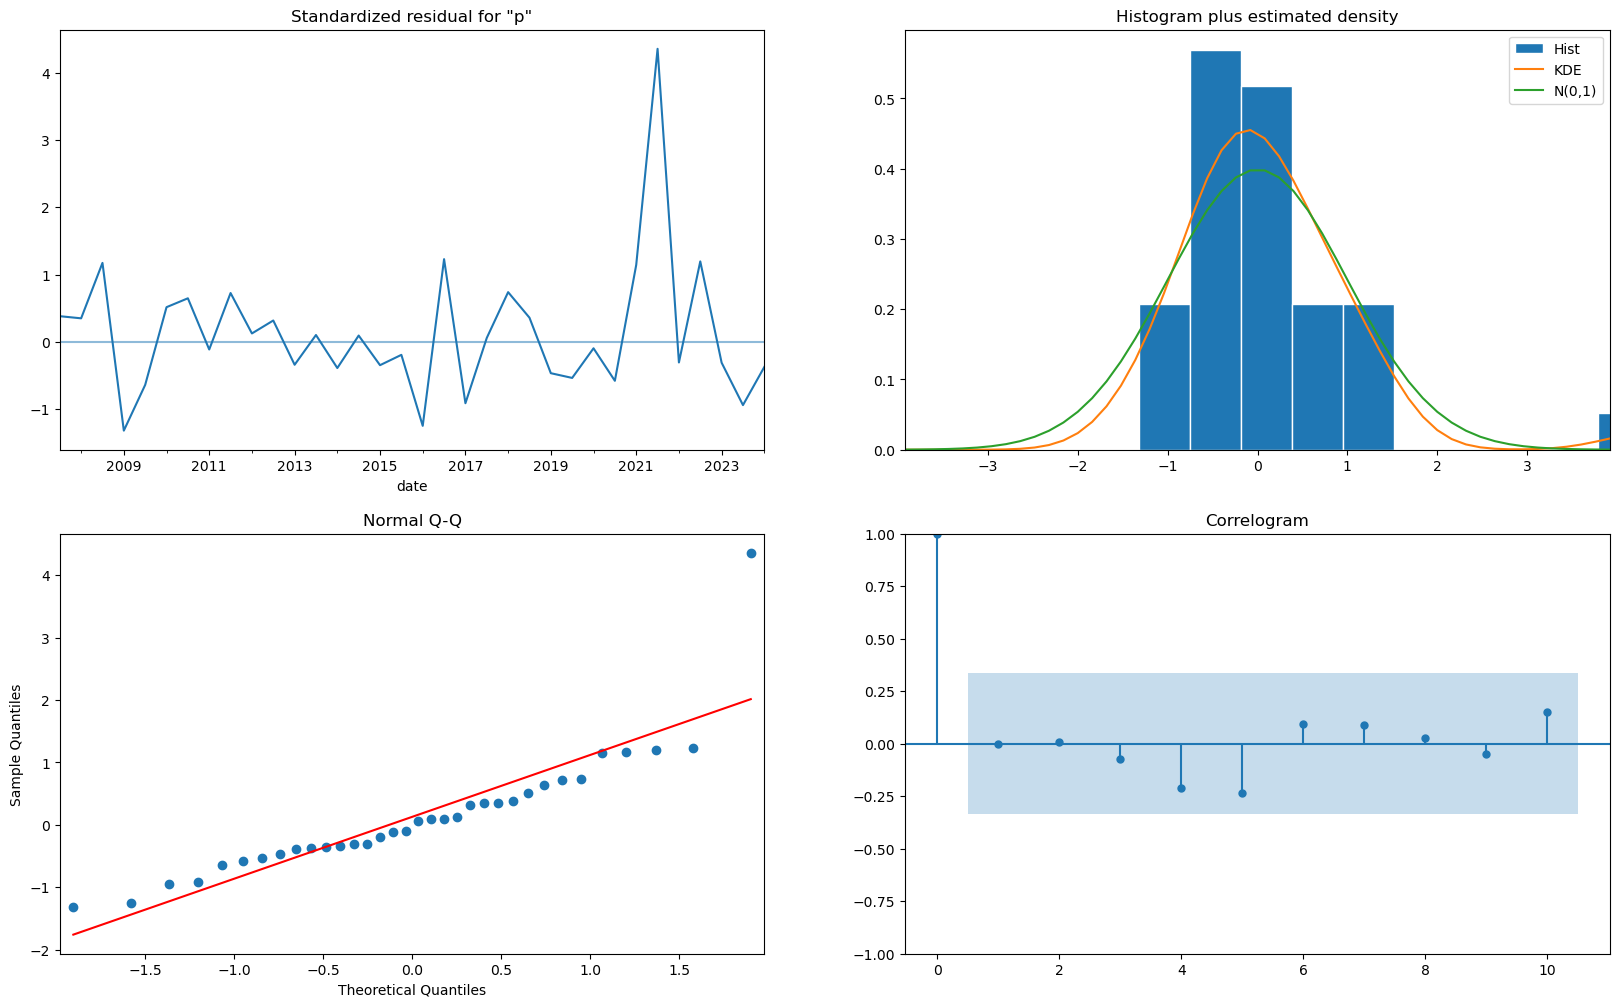

In [147]:
model_fit.plot_diagnostics(figsize = (20, 12))
plt.show()

In [148]:
print(f"L'erreur absolue moyenne du modèle SARIMAX GAZ est de : {np.round(np.exp(model_fit.mae)*1E1, 3)} €/MWh")

L'erreur absolue moyenne du modèle SARIMAX GAZ est de : 11.043 €/MWh


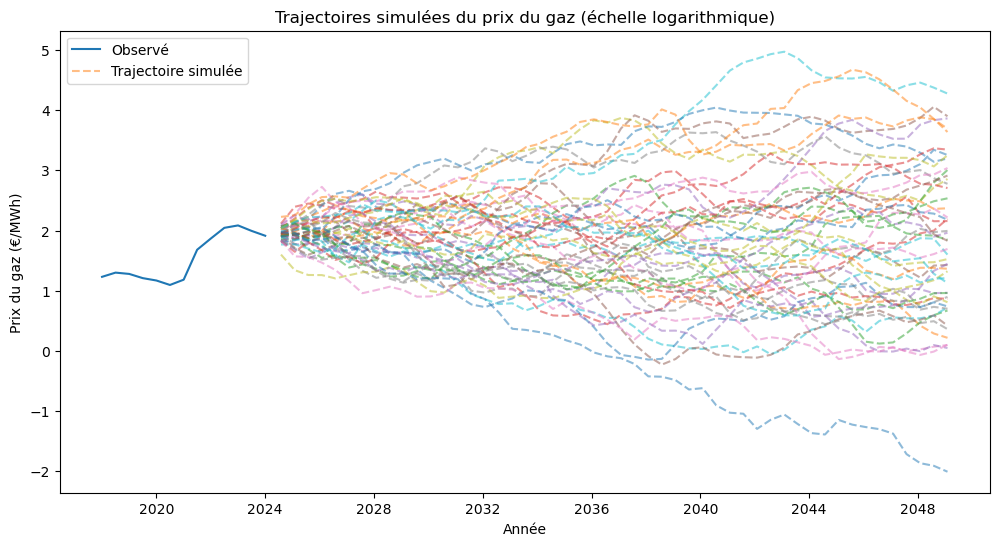

In [149]:
forecast_steps = 50   
n_simulations = 50
simulated_paths = [] 

last_index = df_gaz.index[-1]

for i in range(n_simulations):
    sim = model_fit.simulate(forecast_steps, anchor=last_index)

    sim.index = pd.date_range(start=last_index, periods=forecast_steps+1, freq='6ME')[1:]
    
    simulated_paths.append(sim)

### Visualisation 
plt.figure(figsize=(12, 6))

visu_gaz = df_gaz['2018':]
plt.plot(visu_gaz.index, visu_gaz, label='Observé')

for i, sim in enumerate(simulated_paths):
    plt.plot(sim.index, sim, linestyle='--', alpha=0.5,
             label='Trajectoire simulée' if i == 0 else None) 

plt.xlabel('Année')
plt.ylabel('Prix du gaz (€/MWh)')
plt.title("Trajectoires simulées du prix du gaz (échelle logarithmique)")
plt.legend(loc='upper left')
plt.show()

### Diagnostic d'effet ARCH

In [150]:
from statsmodels.stats.diagnostic import het_arch

# Test d'Engle sur les résidus
test_arch = het_arch(model_fit.resid)
print("Statistique ARCH : ", test_arch[0])
print("p-value : ", test_arch[1])

Statistique ARCH :  0.8953677466469605
p-value :  0.996344574640881


## Analyse historique des prix du pétrole

In [247]:
df_gazole = pd.read_csv("C:/Users/simon.senegas/Documents/Model_TCO_V11.3/Bibliographie/energy prices/prix petrole/2.1.-Prix-industriels-Petrole.2024-11.csv", sep=";")

In [248]:
df_gazole["date"] = pd.to_datetime(df_gazole["Période"], format="%Y-%m")
df_gazole = df_gazole.sort_values(by="Période").dropna()
df_gazole.set_index("date", inplace=True)
df_gazole = df_gazole.drop(columns="Période")
df_gazole = df_gazole.rename(columns={"Prix au détail de 100 kWh PCI de FOL TBTS" : "prix"})
df_gazole = np.log(df_gazole) #MWh

In [249]:
df_gazole.head()

,prix
date,
2007-01-01,0.701363
2007-02-01,0.770710
2007-03-01,0.814612
2007-04-01,0.923902
2007-05-01,0.963632


<Axes: xlabel='date'>

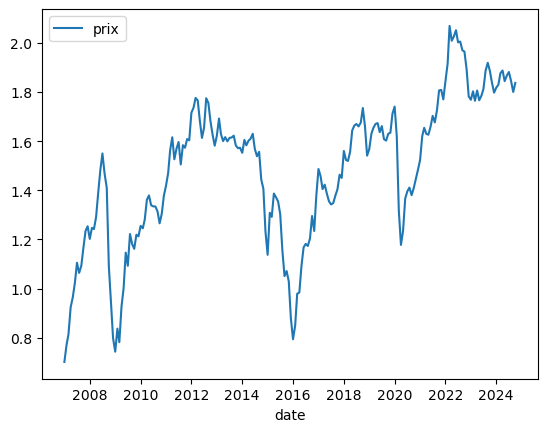

In [250]:
sns.lineplot(df_gazole)

In [251]:
analyze_stationarity(df_gazole)

{'Test statistic': -2.8036606190072426,
 'p-value': 0.05775277424817467,
 'critical Values': {'1%': -3.4615775784078466,
  '5%': -2.875271898983725,
  '10%': -2.5740891037735847}}

In [252]:
ts, d = iterative_differenciation(df_gazole)
print(f'ordre de différenciation {d}')

ordre de différenciation 1


<Axes: xlabel='date'>

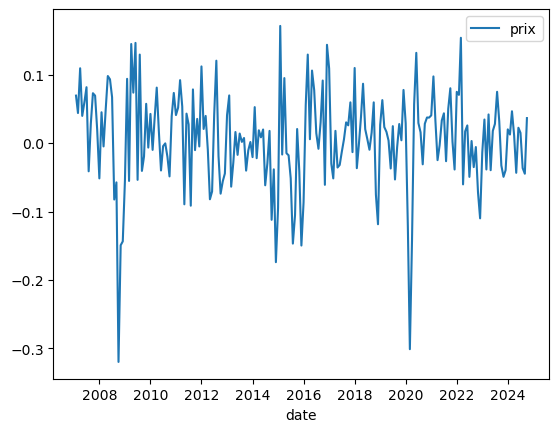

In [253]:
sns.lineplot(ts)

In [254]:
ts.shape

(213, 1)

### ACF, PACF 

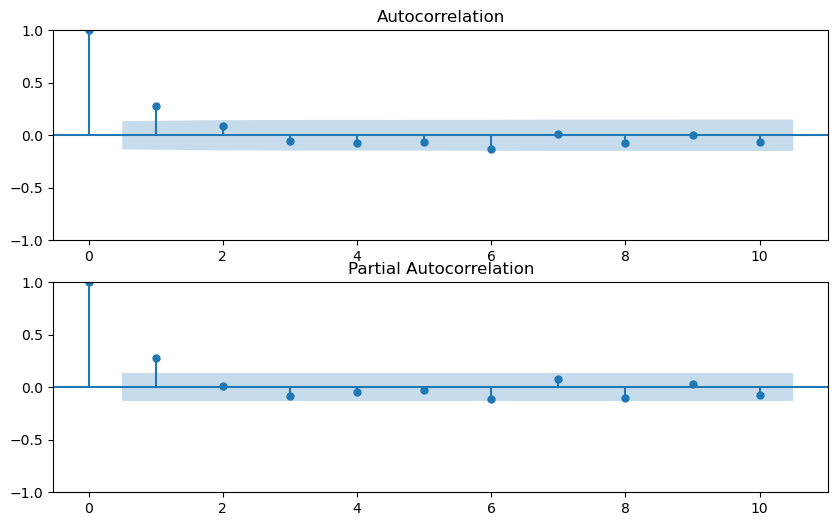

In [255]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
sm.graphics.tsa.plot_acf(ts.dropna(), lags=10, ax=ax[0])
sm.graphics.tsa.plot_pacf(ts.dropna(), lags=10, ax=ax[1])
plt.show()

p et q sont égaux à 1 selon l'ACF et le PACF.

                               SARIMAX Results                                
Dep. Variable:                   prix   No. Observations:                  214
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 273.492
Date:                Tue, 11 Feb 2025   AIC                           -542.985
Time:                        11:07:30   BIC                           -536.262
Sample:                    01-01-2007   HQIC                          -540.268
                         - 10-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2875      0.062      4.656      0.000       0.166       0.408
sigma2         0.0045      0.000     14.647      0.000       0.004       0.005
Ljung-Box (L1) (Q):                   0.01   Jarque-

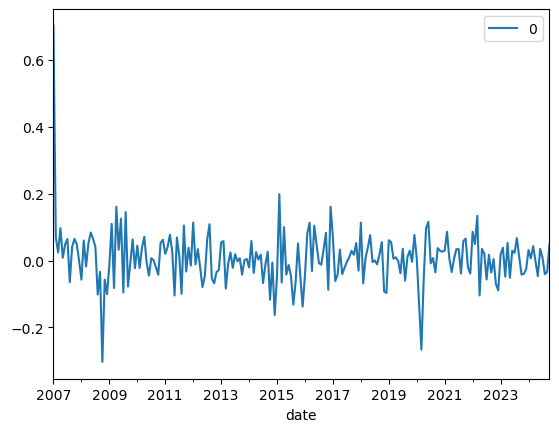

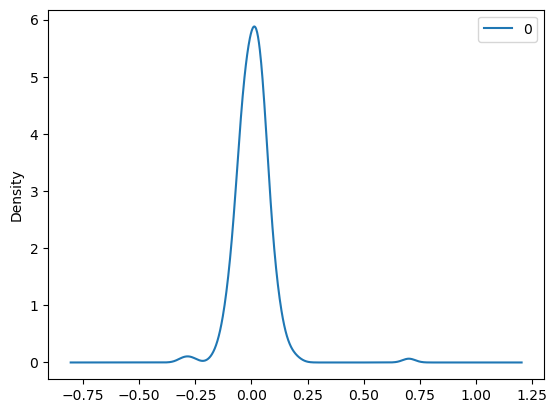

                0
count  214.000000
mean     0.007108
std      0.082151
min     -0.303220
25%     -0.038777
50%      0.006726
75%      0.048386
max      0.701363


In [256]:
model_oil = sm.tsa.statespace.SARIMAX(df_gazole.asfreq("MS"), order=(1,1,0)) # seasonal_order=(0,1,0,6))
model_fit_oil = model_oil.fit()
print(model_fit_oil.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit_oil.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print (residuals.describe())

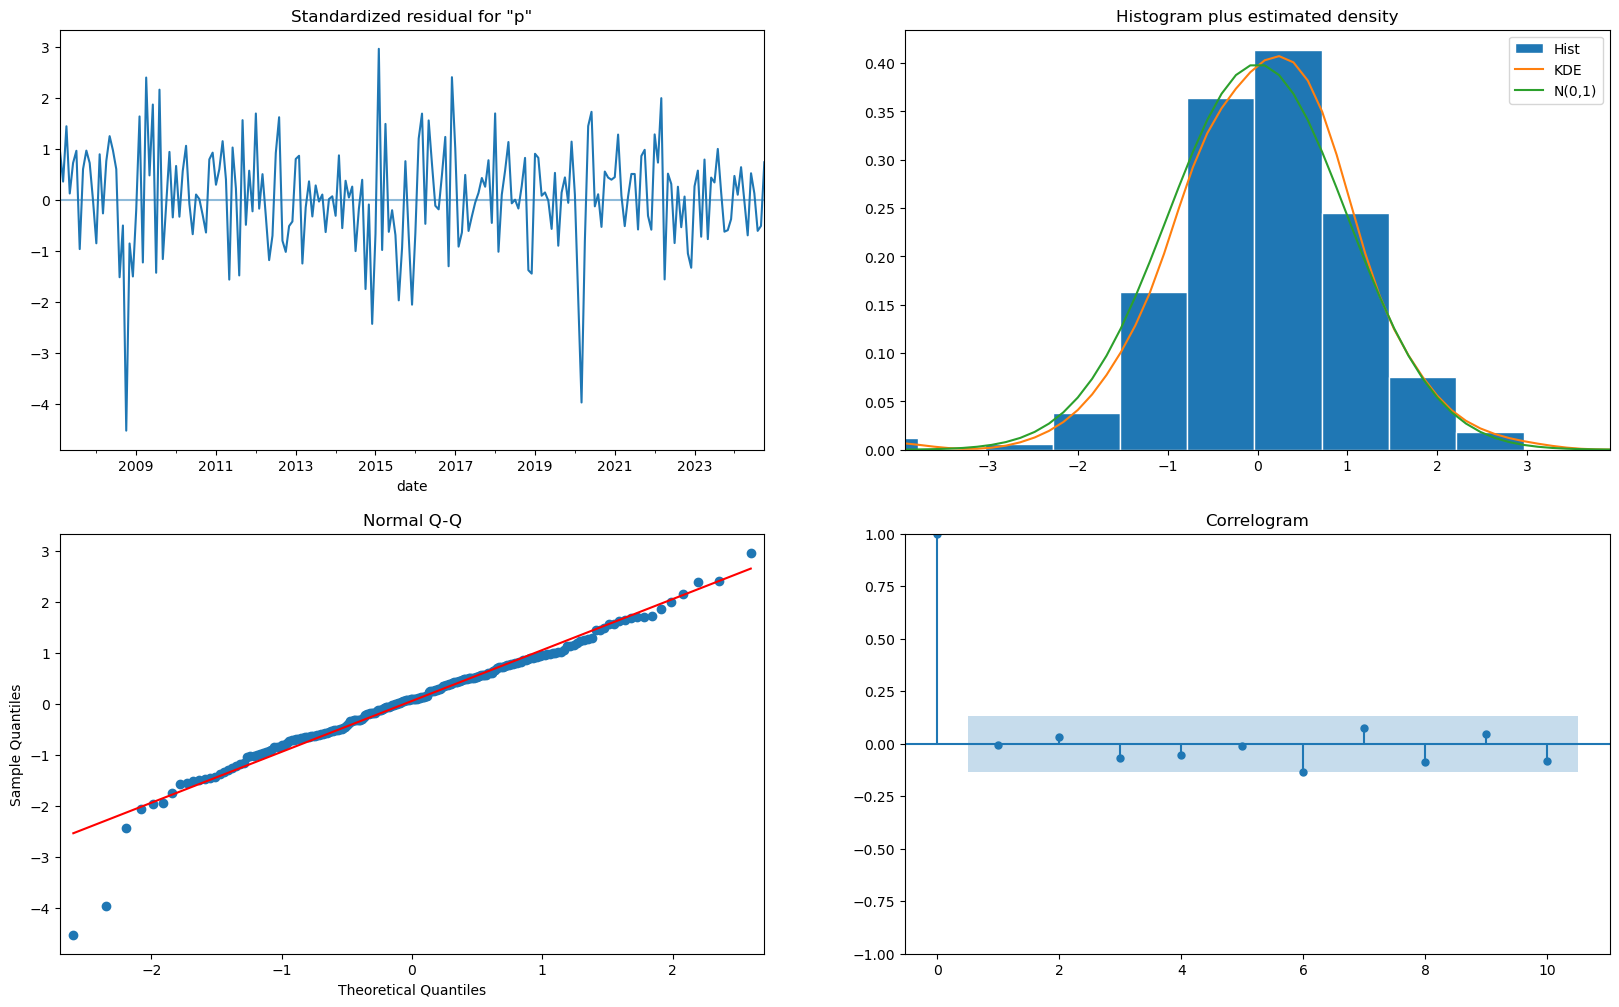

In [257]:
model_fit_oil.plot_diagnostics(figsize = (20, 12))
plt.show()

In [258]:
print(f"L'erreur absolue moyenne du modèle SARIMAX OIL est de : {np.round(np.exp(model_fit_oil.mae)*1E1, 3)} €/MWh")

L'erreur absolue moyenne du modèle SARIMAX OIL est de : 10.555 €/MWh


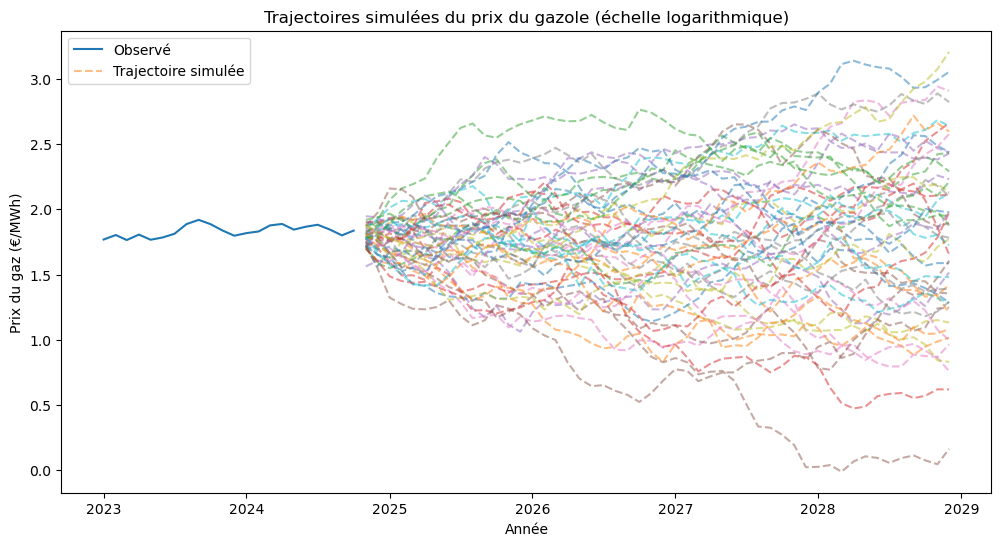

In [259]:
forecast_steps = 50   
n_simulations = 50
simulated_paths = [] 

last_index = df_gazole.index[-1]

for i in range(n_simulations):
    sim = model_fit_oil.simulate(forecast_steps, anchor=last_index)

    sim.index = pd.date_range(start=last_index, periods=forecast_steps+1, freq='MS')[1:]
    
    simulated_paths.append(sim)

### Visualisation 
plt.figure(figsize=(12, 6))

visu_gazole = df_gazole['2023':]
plt.plot(visu_gazole.index, visu_gazole, label='Observé')

for i, sim in enumerate(simulated_paths):
    plt.plot(sim.index, sim, linestyle='--', alpha=0.5,
             label='Trajectoire simulée' if i == 0 else None) 

plt.xlabel('Année')
plt.ylabel('Prix du gaz (€/MWh)')
plt.title("Trajectoires simulées du prix du gazole (échelle logarithmique)")
plt.legend(loc='upper left')
plt.show()

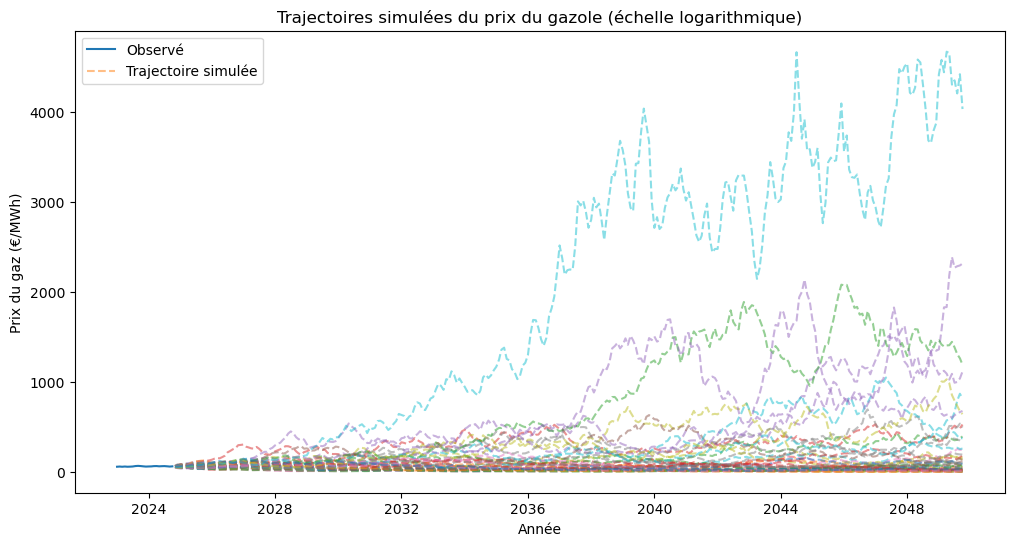

In [266]:
forecast_steps = 300   
n_simulations = 50
simulated_paths = [] 

last_index = df_gazole.index[-1]

for i in range(n_simulations):
    sim = model_fit_oil.simulate(forecast_steps, anchor=last_index)

    sim.index = pd.date_range(start=last_index, periods=forecast_steps+1, freq='MS')[1:]
    
    simulated_paths.append(np.exp(sim)*1E1)

### Visualisation 
plt.figure(figsize=(12, 6))

visu_gazole = np.exp(df_gazole['2023':])*1E1
plt.plot(visu_gazole.index, visu_gazole, label='Observé')

for i, sim in enumerate(simulated_paths):
    plt.plot(sim.index, sim, linestyle='--', alpha=0.5,
             label='Trajectoire simulée' if i == 0 else None) 

plt.xlabel('Année')
plt.ylabel('Prix du gaz (€/MWh)')
plt.title("Trajectoires simulées du prix du gazole (échelle logarithmique)")
plt.legend(loc='upper left')
plt.show()

In [270]:
df_trajectoires = pd.DataFrame(simulated_paths)

<Axes: >

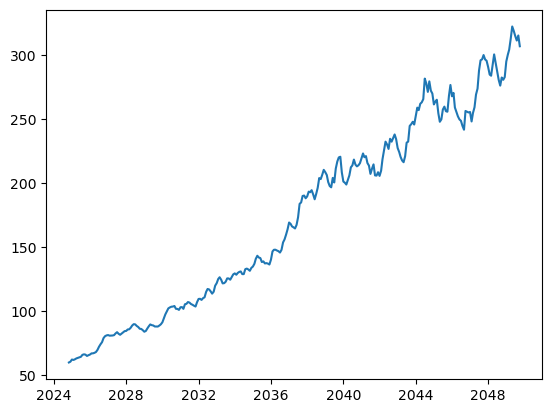

In [271]:
sns.lineplot(df_trajectoires.mean())